# Multidisciplinary Design Optimization of LV4
We propose to apply design optimization methodology to the problem of design and trajectory optimization of small sounding rockets, particularly to the Portland State Aerospace Society's LV4 'space rocket'. This rocket leverages powerful liquid-fuel propulsion, a carbon-composite airframe, 6 DoF attitude control, and has a design apogee of over 100 km, above the so-called von Karman line. LV4 is currently planned for launch by 2021. 

The large amount of coupling between the design decisions in aerospace engineering design presents a singularly defining difficulty in launch vehicle development. In practice this results in a highly iterative design process that demands large investments of resources and time. This also tends to lead to a one-variable-at-a-time design thinking with concomitant requirement mismatches, developmental dead-ends and sub-optimal final design. The Portland State Aerospace Society (PSAS), being a university student group, lacks both time and fiscal support to pursue the traditional iterative approach to launch vehicle design in time for the 2021 vision goal launch date. This provides the motivation for a more targeted approach where design requirements are led by simulation and major design variables are treated all at once using convex optimization techniques. This will guid PSAS's technology development pathways, and inform requirements for future senior capstone projects sponsored by the organization. There is also a certain novelty to this work in the sense that historically there has been little published attention paid to the problem of parameter optimization in clean-sheet design of small sounding rockets.

The objective function is a summation of mass terms for the rocket including propellant, airframe and various subsystem masses. This sum represent a Gross-Lift-Off-Weight (GLOW) parameter which scales closely with design complexity and, ultimately, overall costs. Thus we wish to minimize GLOW subject to constraints including the requirement of a 100 km trajectory apogee, a Thrust-To-Weight-Ratio (TWR) greater than one, a Length-to-Diameter-Ratio (LDR) of less than 20, and a currently unspecified maximum allowable airframe dynamic pressure. Design variables include thrust, airframe diameter and length. The trajectory constraint is a simulation model using forward-Euler integration implemented in Python. There are also a large number of design constants present in the models, which include specific impulse and combustion chamber pressure, mixture ratio among others.

The optimization scheme to be used is yet to be determined, though the nature of the optimization problem is such that it is strongly non-linear with some constraints in the form of discrete simulation outputs.

## Methods
Objective function: minimize $m$  
Design variables: $m_{wet}=f(r, L)$, $m_{dry}=f(F)$, $mdot$, $radius$, $p_e$, $p_ch$  
Constraints: $L/D<15$, $TWR>1$, Sommerfield criterion $(p_e/p_a)>0.35$, $3 < radius < 7$, $x >= 100000$, $a/g_0 <= 15$

Likely going to use a steepest decent with an exterior penalty function based on '''trajectory()''' function calls to check the constraint values.

### Trajectory model

In [15]:
from math import sqrt, pi, exp, log, cos
import numpy as np

# A simple forward Euler integration for rocket trajectories
def dry_mass(L, dia):
    m_avionics = 3.3                       # Avionics mass        [kg]
    m_recovery = 4                         # Recovery system mass [kg]
    m_payload = 2                          # Payload mass         [kg]
    m_tankage = 20.88683068354522*L*dia*pi # Tank mass Estimation [kg]
    m_engine = 2                           # Engine mass          [kg]
    m_feedsys = 20                         # Feed system mass     [kg]
    m_airframe  = 6                        # Airframe mass        [kg]
    return (m_avionics + m_recovery + m_payload + m_tankage 
    + m_engine + m_feedsys + m_airframe)   # Dry mass             [kg]

def propellant_mass(A, L, OF=1.3):
    rho_alc = 852.3             # Density, ethanol fuel [kg/m^3]
    rho_lox = 1141.0            # Density, lox          [kg/m^3]
    L_lox = L/(rho_lox/(rho_alc*OF) + 1)
    m_lox = rho_lox*L_lox*A     # Oxidizer mass         [kg]
    m_alc = rho_alc*(L-L_lox)*A # Fuel mass             [kg]
    return m_alc + m_lox        # Propellant Mass       [kg]

def std_at(h):                  # U.S. 1976 Standard Atmosphere
    if h < 11000:
        T = 15.04 - 0.00649*h
        p = 101.29*((T + 273.1)/288.08)**5.256

    elif 11000 <= h and h <25000:
        T = -56.46
        p = 22.65*exp(1.73 - 0.000157*h)

    else:
        T = -131.21 + 0.00299*h
        p = 2.488 * ((T + 273.1)/216.6)**(-11.388)

    rho = p/(0.2869*(T + 273.1)) # Ambient air density [kg/m^3]
    p_a = p*1000                 # Ambient air pressure [Pa]
    T_a = T + 273.1              # Ambient air temperature [K]
    return p_a, rho, T_a

def thrust(x, p_ch, T_ch, p_e, ke, Re, mdot):
    p_a = std_at(x)[0]                          # Ambient air pressure [Pa]
    p_t = p_ch*(1 + (ke - 1)/2)**(-ke/(ke - 1)) # Throat pressure      [Pa]
    T_t = T_ch*(1/(1 + (ke - 1)/2))             # Throat temperature   [K]
    A_t = (mdot / p_t)*sqrt(Re*T_t/ke)          # Throat area          [m^2]
    A_e = A_t*(2/(ke + 1))**(1/(ke - 1))*(p_ch/p_e)**(1/ke) * 1/sqrt((ke + 1)/(ke - 1)*(1 - (p_e/p_ch)**((ke - 1)/ke))) # Exit area [m^2]
    ex = A_e/A_t              # Expansion ratio
    alpha_t = [14, 11, 10, 9] # Lookup table of divergence angles, assuming 80% bell length
    ex_t = [5, 10, 15, 20]    # Lookup table of expansion ratios from alpha_t
    alpha= np.interp(ex, ex_t, alpha_t)
    lam = 0.5*(1 + cos(alpha *pi/180)) # Thrust cosine loss correction, even in extreme cases this is definitely not an O(1) effect 
    Ve = lam*sqrt(2*ke/(ke - 1)*Re*T_ch*(1 - (p_e/p_ch)**((ke - 1)/ke))) # Exhaust velocity                                  [m/s]
    F = mdot*Ve + (p_e - p_a)*A_e                                        # Thrust force, ignoring that isp increases w/ p_ch [N]
    return F, A_t, A_e, Ve

def drag(x, v, A, Ma):
    # Check Knudsen number and switch drag models (e.g. rarified gas dyn vs. quadratic drag)
    (p_a, rho, T_a) = std_at(x)
    C_d_t = [0.15, 0.15, 0.3, 0.45, 0.25, 0.2, 0.175, .15, .15] # V2 rocket drag coefficient lookup table
    Ma_t = [0, 0.6, 1.0, 1.1, 2, 3, 4, 5, 5.6]                  # V2 rocket Mach number lookup table
    C_d = np.interp(Ma, Ma_t, C_d_t)                            # Drag coefficient function
    q = 0.5 * rho * v**2                                        # Dyanmic pressure [Pa]
    D = q * C_d * A                                             # Drag force       [N]
    return D, q

def trajectory(L, mdot, dia, p_e, p_ch=350, T_ch=3500, ke=1.3, Re=349, x_init=0):
    # Note combustion gas properties ke, Re, T_ch, etc, determined from CEA
    # Physical constants
    g_0 = 9.81 # Gravitational acceleration [m/s^2]
    dt = 1     # Time step                  [s]
    ka = 1.4   # Ratio of specific heats, air  
    Ra = 287.1 # Avg. specific gas constant (dry air)
    
    # LV4 design variables
    dia = dia*0.0254       # Convert in. to m
    A = pi*(dia/2)**2      # Airframe frontal area projected onto a circle of diameter variable dia
    m_dry = dry_mass(L, A) # Dry mass, call from function dry_mass()
    mdot = mdot            # Mass flow rate [kg/s]
    p_ch = p_ch*6894.76    # Chamber pressure, convert psi to Pa
    p_e = p_e*1000         # Exit pressure, convert kPa to Pa

    # Initial conditions
    x = [x_init]
    v = [0]
    a = [0]
    t = [0]
    rho = [std_at(x[-1])[1]]
    p_a = [std_at(x[-1])[0]]
    T_a = [std_at(x[-1])[2]]
    m_prop = [propellant_mass(A, L)]
    m = [m_dry + m_prop[-1]]
    (F, A_t, A_e, Ve) = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
    F = [F]
    D = [0]
    Ma = [0]
    q = [0]
    r = (m_prop[0] + m_dry)/m_dry # Mass ratio
    dV1 = Ve*log(r)/1000          # Tsiolkovsky's bane (delta-V)

    while True:
        p_a.append(std_at(x[-1])[0])
        rho.append(std_at(x[-1])[1])
        T_a.append(std_at(x[-1])[2])
        # Check of the propellant tanks are empty
        if m_prop[-1] > 0:
            (Fr, A_t, A_e, Ve) = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
            F.append(Fr)
            m_prop.append(m_prop[-1] - mdot*dt)
            mdot_old = mdot
        else:
            Ve = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot_old)[3]
            F.append(0)
            mdot = 0
            m_prop[-1] = 0
        q.append(drag(x[-1], v[-1], A, Ma[-1])[1])
        D.append(drag(x[-1], v[-1], A, Ma[-1])[0])
        a.append((F[-1] - D[-1])/m[-1] - g_0)
        v.append(a[-1]*dt + v[-1])
        x.append(v[-1]*dt + x[-1]) 
        Ma.append(v[-1]/sqrt(ka*Ra*T_a[-1]))
        t.append(t[-1] + dt)
        m.append(m_dry + m_prop[-1])
        TWR = a[1]/g_0      # Thrust-to-weight ratio constraint
        ex = A_e/A_t
        S_crit = p_e/p_a[0] # Sommerfield criterion constraint
        if v[-1] <= 0:
            x = np.array(x)
            a = np.array(a)
            F = np.array(F)
            D = np.array(D)
            q = np.array(q)
            return x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop


## Current Takeaways:
min GLOW probably around 100 kg. In many ways narrower diameters are ideal, but run up against the $L/D$ constraints. High thrust can be good or bad depending on the confuration. Finding ways to reduce the length of the rocket looks like a good path to better performance.

## Airframe Section Parameters

These are parameters from the current 18 in. airframe section.

In [16]:
# Airframe Section Parameters
from math import pi
m  = 0.463 # Single LV3 airframe module mass [kg], 18 in.
Do = 0.168 # Outer diameter                  [m]
L  = 0.457 # Length                          [m]
A_fiber = pi* (Do/2)**2 
rho_fiber = m/A_fiber # Planar density       [kg/m^2]
print("Module planar density = {0:.2f} kg/m^2".format(rho_fiber))

Module planar density = 20.89 kg/m^2


## Optimization Scheme
Simplex search with exterior penalty functions

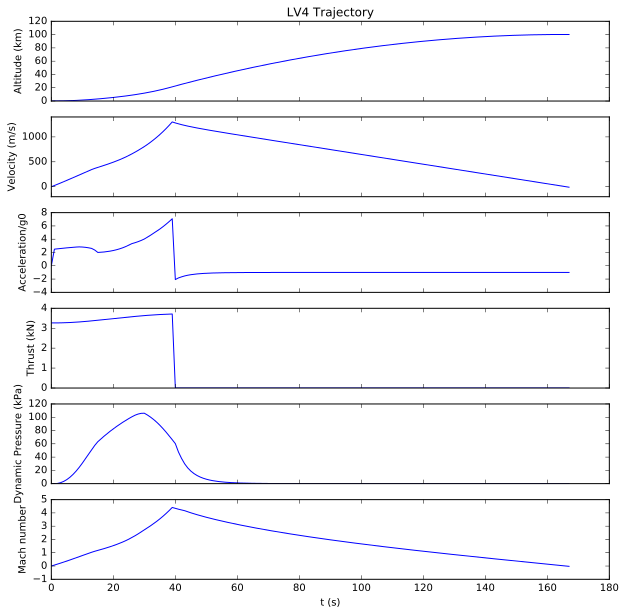



OPTIMIZED DESIGN VECTOR
-----------------------------
x_optimized     =  [  1.298   1.425   9.096  66.691]
x_initial_guess =  [  1.      1.633  12.     50.   ]
design tankage length       = 1.30 m
design mass flow rate       = 1.42 kg/s
design airframe diameter    = 9.10 in.
design nozzle exit pressure = 66.69 kPa
iterations  =  346
design GLOW = 95.0 kg
x0 GLOW     =  114.654715233


CONSTRAINTS
-----------------------------
L/D ratio (check < 15)                     = 14.28
Sommerfield criterion (check pe/pa >= 0.3) = 0.7
Max acceleration (check < 15)              = 7.08
TWR at lift off (check TWR > 2)            = 2.50
altitude at apogee                         = 100.2 km


ADDITIONAL INFORMATION
-----------------------------
mission time at apogee       = 167.0 s
design total propellant mass = 54.139
design thrust (sea level)    = 3.3 kN
design thrust (vacuum)       = 3.7 kN
design burn time             = 40 s
design expansion ratio       = 4.8
design throat area           = 1.5 

In [17]:
# Class simplex: 
# Nelder-Mead simplex search
import numpy as np
from math import sqrt, pi, exp, log, cos
import math as m

def search(f, x_start, max_iter = 100, gamma = 5, beta = 0.5, rp=100, a=10, epsilon = 1E-6):
    """
    parameters of the function:
    f is the function to be optimized
    x_start (numpy array) is the initial simplex vertices
    epsilon is the termination criteria
    gamma is the contraction coefficient
    beta is the expansion coefficient
    """
    # Init Arrays
    N = len(x_start)     # Amount of design variables
    fb = []              # Empty function matrix
    xnew = []            # Empty re-write for design variables
    x    = []            # Empty x matrix
    C    = [[0]*N]*(N+1) # Empty center point matrix #####CHANGED
    
    # Generate vertices of initial simplex
    x0 = (x_start)   # x0 Value for x Matrix
    x1 = [x0 + [((N + 1)**0.5 + N - 1.)/(N + 1.)*a, 0., 0., 0.]]
    x2 = [x0 + [0., ((N + 1)**0.5 - 1.)/(N + 1.)*a, 0., 0.]]
    x3 = [x0 + [0., 0., ((N + 1)**0.5 - 1.)/(N + 1.)*a, 0.]]
    x4 = [x0 + [0., 0., 0., ((N + 1)**0.5 - 1.)/(N + 1.)*a]]
    x = np.vstack((x0, x1, x2, x3, x4))

    # Simplex iteration
    while True:
        # Find best, worst, 2nd worst, and new center point
        f_run = np.array([f(x[0], rp), f(x[1], rp), f(x[2], rp), f(x[3], rp), f(x[4], rp)]).tolist() # Func. values at vertices
        xw = x[f_run.index(sorted(f_run)[-1])] # Worst point
        xb = x[f_run.index(sorted(f_run)[0])]  # Best point
        xs = x[f_run.index(sorted(f_run)[-2])] # 2nd worst point        
        for i in range(0, N+1):
            if i == f_run.index(sorted(f_run)[-1]):
                C[i] = [0,0,0,0]
            else:
                C[i] = x[i].tolist()
        xc = sum(np.array(C))/(N) # Center point
        xr = 2*xc - xw            # Reflection point
        fxr = f(xr, rp)
        fxc = f(xc, rp)
        
        # Check cases
        # f(xr, rp) < f(xb, rp): # Expansion
        if fxr < f_run[f_run.index(sorted(f_run)[0])]:    
            xnew = (1 + gamma)*xc - gamma*xr
        # f(xr, rp) > f(xw, rp): # Contraction 1
        elif fxr > f_run[f_run.index(sorted(f_run)[-1])]:
            xnew = (1 - beta)*xc + beta*xw
        # f(xs, rp) < f(xr, rp) and f(xr, rp) < f(xw, rp): # Contraction 2
        elif f_run[f_run.index(sorted(f_run)[-2])] < fxr and fxr < f_run[f_run.index(sorted(f_run)[-1])]: 
            xnew = (1 + beta)*xc - beta*xw
        else:
            xnew = xr
        
        # Replace Vertices
        x[f_run.index(sorted(f_run)[-1])] = xnew
        #x[f_run.index(sorted(f_run)[1])] = xb # Replace best
        #x[f_run.index(sorted(f_run)[2])] = xs # Replace second best
        fb.append(f(xb, rp))
        print('Current optimum = ', fb[-1])
        
        # Break if any termination critera is satisfied
        if len(fb) == max_iter: #or term_check(x, xc, xw, N, rp, f_run) <= epsilon:
            (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop, p_ch) = trajectory(xb[0], xb[1], xb[2], xb[3])
            return f(x[f_run.index(sorted(f_run)[0])], rp), x[f_run.index(sorted(f_run)[0])], len(fb)
        
def term_check(N, rp, f_run, fxc): # Termination critera
    M = [0]*(N + 1)
    for i in range(0, N + 1):
        if i == f_run.index(sorted(f_run)[-1]): # Avoid worst point
            M[i] = 0
        else:
            M[i] = (f_run[i] - fxc)**2
    return m.sqrt(sum(M)/N)
        
# Pseudo-objective function
def f(x, p_ch=350, rp=50): ##CHANGE CHAMBER PRESSURE HERE
    L = x[0]    # Rocket length (m)
    mdot = x[1] # Propellant mass flow rate (kg/s)
    dia = x[2]  # Rocket diameter (in)
    p_e = x[3]  # Pressure (kPa)
    (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = trajectory(L, mdot, dia, p_e, p_ch)
    #CHANGE CONSTRAINTS HERE
    obj_func = m[0] + rp*(max(0, (L+2)/(dia*0.0254) - 15)**2 + max(0, -TWR + 2)**2 + max(0, -S_crit + 0.35)**2 + max(0, -alt[-1] + 100000)**2 + max(0, max(abs(a))/9.81 - 15)**2)   
    return obj_func

if __name__ == '__main__': # Testing
    ##CHANGE INITIAL DESIGN GUESS HERE
    X0 = np.array([1, 0.453592 * 0.9 * 4, 12, 50])
    #X0 = np.array([2, 0.453592 * 0.9 * 6, 8, 50])
    """max_iter = 200
    rp = 50
    gamma = 6
    beta = .5
    a = 5
    (f, x, it) = search(f, np.array(X0), max_iter, gamma, beta, rp, a)
    """
    from scipy.optimize import minimize
    res = minimize(f, X0, method='nelder-mead')    
    
    p_ch = 350 # Chamber pressure [kPa] **DONT FORGET TO CHANGE THE VALUE IN THE OBJECTIVE FUNCTION IN def f()**
    (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = trajectory(res.x[0], res.x[1], res.x[2], res.x[3], p_ch)   
    print('\n')
    
    # Plot the results
    import matplotlib
    import matplotlib.pyplot as plt
    import pylab
    %config InlineBackend.figure_formats=['svg']
    %matplotlib inline
    # Redefine the optimized output
    L = res.x[0]    
    mdot = res.x[1]
    dia = res.x[2]
    p_e = res.x[3]
    
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    f, (ax1, ax2, ax3, ax4, ax6, ax7) = plt.subplots(6, sharex=True)
    ax1.plot(t, alt/1000)
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    ax2.plot(t, v)
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    ax3.plot(t, a/9.81)
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g0")
    ax4.plot(t, F/1000)
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    ax6.plot(t, q/1000)
    ax6.yaxis.major.locator.set_params(nbins=6)
    ax6.set_ylabel("Dynamic Pressure (kPa)")
    ax7.plot(t, Ma)
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("Mach number")
    ax7.set_xlabel("t (s)")
    plt.show()
    
    np.set_printoptions(precision=3)
    print('\n')
    print('OPTIMIZED DESIGN VECTOR')
    print('-----------------------------')
    print('x_optimized     = ', res.x)
    print('x_initial_guess = ', X0)
    print('design tankage length       = {0:.2f} m'.format(res.x[0]))
    print('design mass flow rate       = {0:.2f} kg/s'.format(res.x[1]))
    print('design airframe diameter    = {0:.2f} in.'.format(res.x[2]))
    print('design nozzle exit pressure = {0:.2f} kPa'.format(res.x[3]))
    print('iterations  = ', res.nit)
    print('design GLOW = {0:.1f} kg'.format(m[0]))
    print('x0 GLOW     = ', trajectory(X0[0], X0[1], X0[2], X0[3], p_ch)[-4][0])
    
    print('\n')
    print('CONSTRAINTS')
    print('-----------------------------')
    print('L/D ratio (check < 15)                     = {0:.2f}'.format((L+2)/(dia*0.0254)))
    print('Sommerfield criterion (check pe/pa >= 0.3) = {0:.1f}'.format(S_crit))
    print('Max acceleration (check < 15)              = {0:.2f}'.format(max(abs(a))/9.81))
    print('TWR at lift off (check TWR > 2)            = {0:.2f}'.format(TWR))
    print('altitude at apogee                         = {0:.1f} km'.format(alt[-1]/1000))
    
    print('\n')
    print('ADDITIONAL INFORMATION')
    print('-----------------------------')
    print('mission time at apogee       = {0:.1f} s'.format(t[-1]))
    print('design total propellant mass = {0:.3f}'.format(m_prop[0]))
    print('design thrust (sea level)    = {0:.1f} kN'.format(F[0]/1000))
    j = 0
    for thing in F:
        if thing == 0:
            fdex = j
            break
        j += 1
    print('design thrust (vacuum)       = {0:.1f} kN'.format(F[fdex - 1]/1000))
    print('design burn time             = {} s'.format(fdex))
    print('design expansion ratio       = {0:.1f}'.format(ex))
    print('design throat area           = {0:.1f} in.^2'.format(A_t/0.0254**2))
    print('design isp                   = {0:.1f} s'.format(Ve/9.81))
    print('design chamber pressure      = {0:.1f} psi'.format(p_ch))
    print('design dV = {} km/s c.f. required potential energy est = {} km/s'.format(dV1, sqrt(2*9.81*alt[-1])/1000))
    

## A Warning
At present there are some substantial implied limitations to the model as a useful design tool for LV4. The dry mass is based on some very rough estimations, and the optimization results are very sensitive to it. I've tried to deal with this by being conservative in my estimates. The tank mass model is probably optimistic in the sense that it uses the current LV3 carbon fiber planar density as a guide to LV4 tank weights. It also does not take into account ullave volume and other neccessary wasted space the nonetheless increases the tank mass. We presently do not know if the LV3 CF technology will work as supposed as a pressure vessel in the LV4 diamaters, post-hoc FEA  (and probably some empirical work) is needed to verify this assumption. Another issues is the drag coeficients, these presently use historical data from the V-2 rocket. While this may work as a first approximation, it is a significant source of error. This can be remedied by using a substantially more complex aerodynamics model in this simulation or otherwise post-hoc analysis in Star-CCM+ or another CFD program. The drag coefficients are expected to be largely functions of the fin geometry, which itself depends on static stability analysis. Thus despite a working optimization scheme some recursive analyisis is still required (though vastly less than we might otherwise be forced to do). 